<a href="https://colab.research.google.com/github/3ndung/H8_PTP_Final_Image/blob/master/CatNDog_With_TF_HUB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
import tensorflow_hub as hub

TensorFlow 2.x selected.


In [4]:
print(tf.__version__)
print(hub.__version__)

2.1.0
0.7.0


# Load Data from source

we wil re-use existing data from googleapis

In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt


In [0]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

In [9]:
!ls /root/.keras/datasets/cats_and_dogs_filtered/

train  validation  vectorize.py


Set Train Path Only


In [0]:
TPATH = '/root/.keras/datasets/cats_and_dogs_filtered/train/'

In [14]:
IMAGE_SHAPE = (224, 224)
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(TPATH, target_size=IMAGE_SHAPE)

Found 2000 images belonging to 2 classes.


In [15]:
for image_batch, label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 2)


**Litte Note**

actually the function of ImageDataGenerator is to convet image into array format

you try by yourself with type image_batch[0]

Since we have two classes , the label would be [0,1] or [1,0]

In [24]:
print(label_batch[0])
print(label_batch[6])

[0. 1.]
[1. 0.]


In [0]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2" #@param {type:"string"}

In [28]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))

feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


if we dont want training anymore

In [0]:
feature_extractor_layer.trainable = False

Make Model with hub

In [30]:
model = tf.keras.Sequential([
  #feature_extractor_layer, 
  hub.KerasLayer(feature_extractor_url,input_shape=(224,224,3),trainable=False),
  tf.keras.layers.Dense(image_data.num_classes)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [32]:
predictions = model(image_batch)
predictions.shape

TensorShape([32, 2])

In [0]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [0]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['accuracy'])
    self.model.reset_metrics()

In [37]:
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit_generator(image_data, epochs=2,
                              steps_per_epoch=steps_per_epoch,
                              callbacks = [batch_stats_callback])

Instructions for updating:
Please use Model.fit, which supports generators.


Instructions for updating:
Please use Model.fit, which supports generators.


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 63.0 steps
Epoch 1/2
63/63 [==============================] - 9s 142ms/step - loss: 0.2479 - accuracy: 1.0000
Epoch 2/2
63/63 [==============================] - 7s 110ms/step - loss: 0.0619 - accuracy: 0.9688


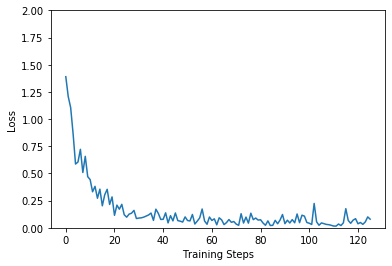

In [40]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

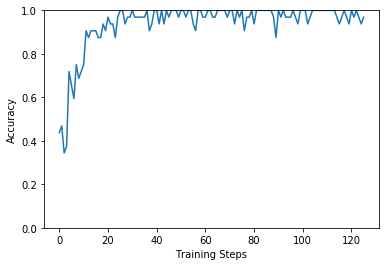

In [41]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

In [42]:
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['Cats', 'Dogs'], dtype='<U4')

In [47]:
class_names[0]='CAT'
class_names[1]='DOG'

print(class_names)

['CAT' 'DOG']


In [0]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

In [0]:
label_id = np.argmax(label_batch, axis=-1)

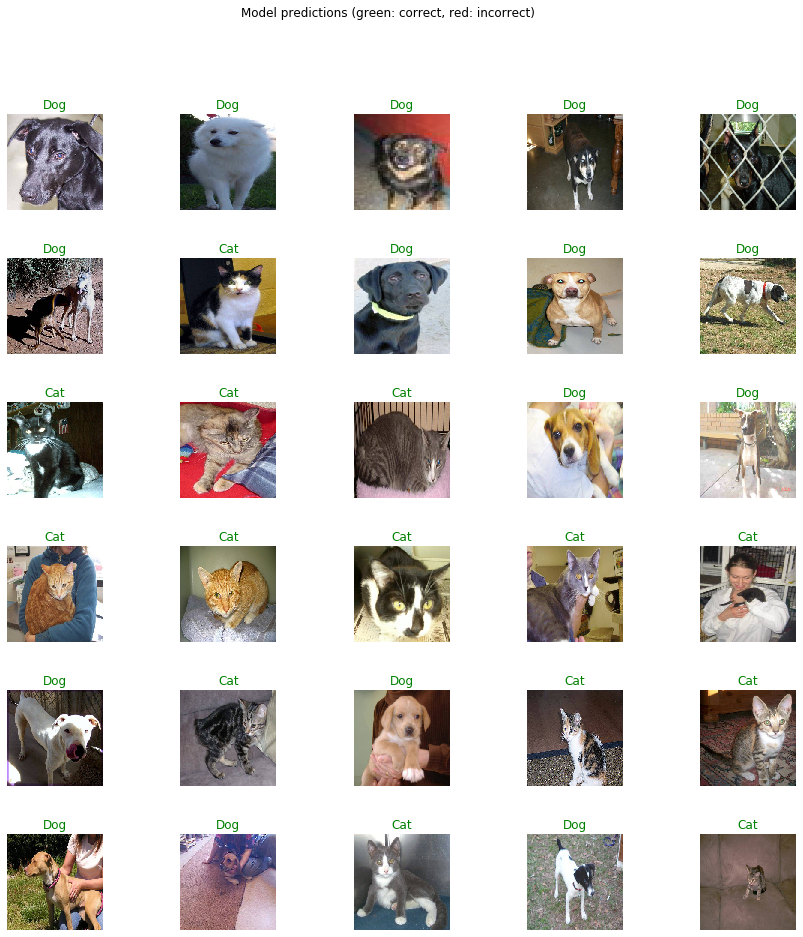

In [51]:
plt.figure(figsize=(15,15))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

In [0]:
model.save('BGS_CATS_DOGS_W_HUB.h5')